In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

np.random.seed(2024)

# Plot settings
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 13
sns.set(style="whitegrid")

interesse = pd.read_csv("data/interesse.csv")
alter_geschlecht = pd.read_csv("data/alter_geschlecht.csv")
rest = pd.read_csv("data/rest.csv", sep=";")

[interesse.shape[0], alter_geschlecht.shape[0], rest.shape[0]]

[381109, 508146, 508146]

In [4]:
utils.display_side_by_side(
    interesse.head(), rest.head(), alter_geschlecht.head(),
    titles=["interesse", "rest", "alter_geschlecht"]
)

interesse 
 
 
 
 id 
 Interesse 
 
 
 
 
 0 
 1 
 1.0 
 
 
 1 
 2 
 0.0 
 
 
 2 
 3 
 1.0 
 
 
 3 
 4 
 0.0 
 
 
 4 
 5 
 0.0 
 
 
 rest 
 
 
 
 Fahrerlaubnis 
 Regional_Code 
 Vorversicherung 
 Alter_Fzg 
 Vorschaden 
 Jahresbeitrag 
 Vertriebskanal 
 Kundentreue 
 id 
 
 
 
 
 0 
 1 
 15.0 
 1 
 1-2 Year 
 No 
 2630.0 
 124.0 
 74 
 317635 
 
 
 1 
 1 
 28.0 
 0 
 1-2 Year 
 Yes 
 2630.0 
 125.0 
 213 
 337993 
 
 
 2 
 1 
 33.0 
 0 
 1-2 Year 
 Yes 
 27204.0 
 124.0 
 114 
 160325 
 
 
 3 
 1 
 46.0 
 1 
 < 1 Year 
 No 
 31999.0 
 152.0 
 251 
 141620 
 
 
 4 
 1 
 49.0 
 0 
 1-2 Year 
 Yes 
 28262.0 
 26.0 
 60 
 75060 
 
 
 alter_geschlecht 
 
 
 
 id 
 Geschlecht 
 Alter 
 
 
 
 
 0 
 170727 
 Male 
 42 
 
 
 1 
 41795 
 Male 
 24 
 
 
 2 
 369321 
 Female 
 30 
 
 
 3 
 500463 
 Female 
 32 
 
 
 4 
 327695 
 Male 
 34

In [147]:
{"interesse": interesse.shape, "alter_geschlecht": alter_geschlecht.shape, "rest": rest.shape}

{'interesse': (381109, 2),
 'alter_geschlecht': (508146, 3),
 'rest': (508146, 9)}

In [148]:
# Check if interesse is subset of rest
set(interesse.id) <= set(rest.id)

True

In [149]:
prop_missing = 100*(1-(len(interesse) / len(rest)))
print(f"{prop_missing:.1f}% missing values")

25.0% missing values


### Setup
* Subset of all customers (rest+alter_geschlecht) participated in survey (interest)
* Task: Learn classifier X->Y for customer interest # TODO clarify downstream users of classifier
    - Evaluate on overall customer base # TODO tbd
    - Consider variable misclassification cost as implied by `Jahresbeitrag`
* Problem: Possible self-selected study sample -> no SRS -> invalidates iid assumption -> generalization questionable
  - `25`% missing

### Identifying assumptions

Missing data patterns:

1. Missing-completely-at-random (MCAR) -> $S \!\perp\!\!\!\perp (X,Y)$
    - Survey sample constitutes a random sample from the customer population
2. Missing-at-random (MAR) ->  $S \!\perp\!\!\!\perp Y | X$
    - Selection on observables case. Survey sample is biased but biasedness entirely controlled by covariates $X$
    - Also known as covariate shift
3. Missing-at-random (MAR) ->  $S \!\perp\!\!\!\perp X | Y$
    - Selection on unobservables case. Same as above but biasedness depends on outcome $Y$
4. Not-missing-at-random (NMAR) -> $S \not\!\perp\!\!\!\perp X$,  $S \not\!\perp\!\!\!\perp Y$

-> Proceed under covariate shift assumption (2).

In [2]:
# Join interesse with rest+alter_geschlecht, create selection indicator for participation in survey
interesse["selected"] = 1 # create selection indicator
cbase = pd.merge(rest, alter_geschlecht, how = "left", on = "id") 
cbase = pd.merge(cbase, interesse, how = "left", on = "id")
cbase["selected"] = cbase["selected"].fillna(0)

## Data exploration

In [166]:
# Check for missingness and data types
utils.summarize_columns(cbase)

,# levels,# missing Values
Fahrerlaubnis,2,0
Regional_Code,53,0
Vorversicherung,2,0
Alter_Fzg,3,0
Vorschaden,2,0
Jahresbeitrag,52062,0
Vertriebskanal,10,0
Kundentreue,290,0
id,508146,0
Geschlecht,2,0


In [9]:
interesse["Interesse"].value_counts() / interesse.shape[0] # class imbalance (88% = 0, 12% = 1) 

Interesse
0.0    0.877437
1.0    0.122563
Name: count, dtype: float64

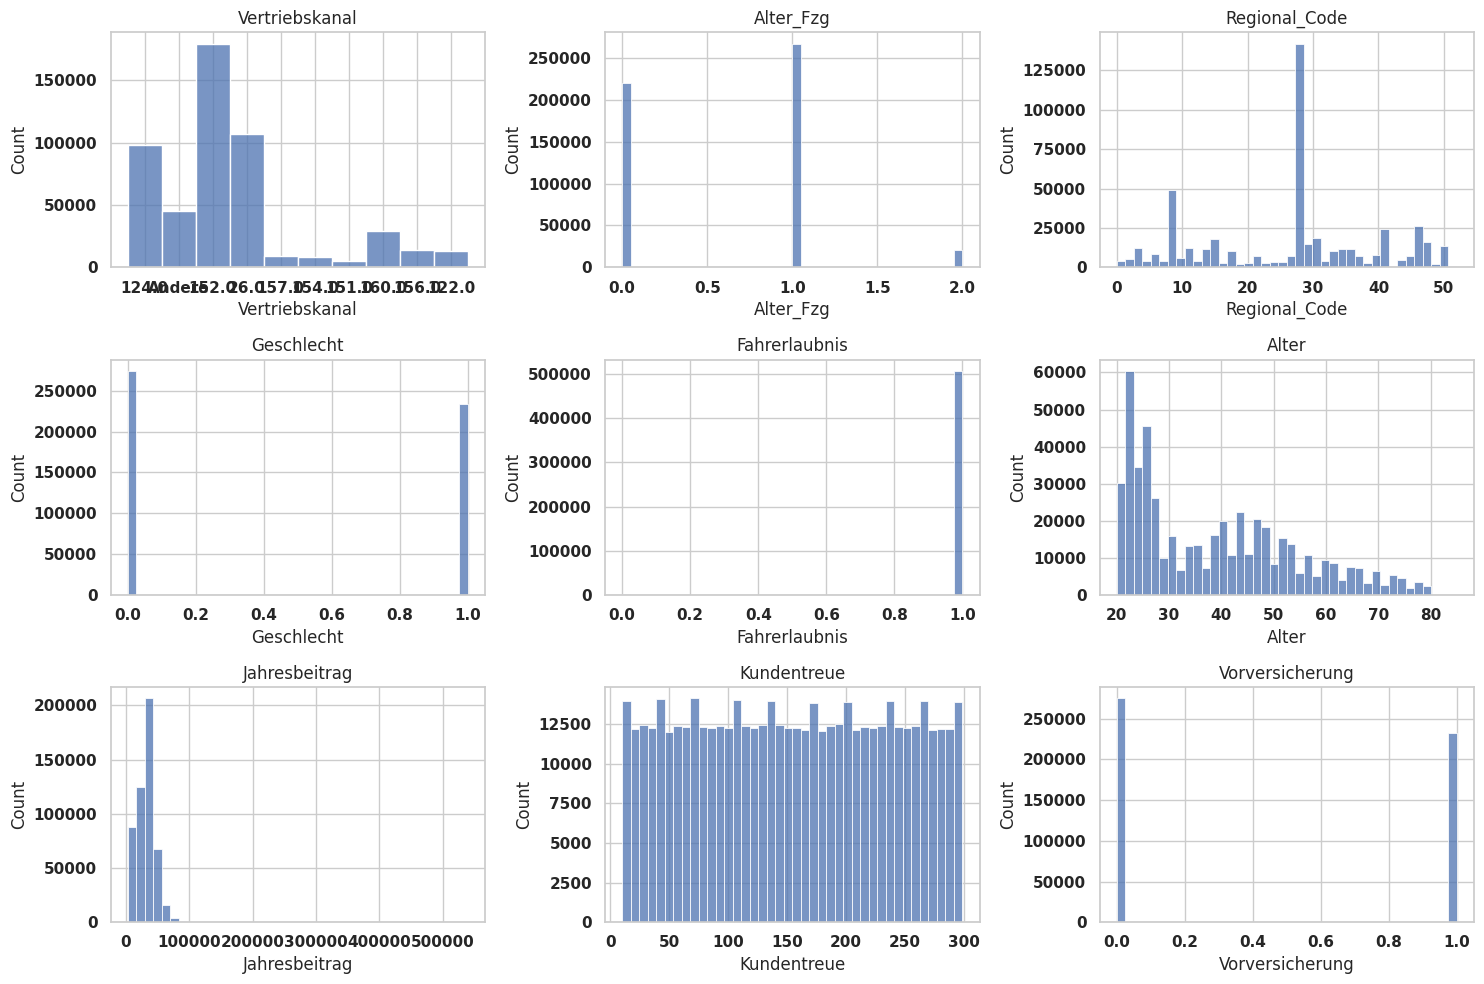

In [150]:
# Select plotting columns
plot_cols = ["Vertriebskanal", "Alter_Fzg", "Regional_Code", "Geschlecht", "Fahrerlaubnis", "Alter", "Jahresbeitrag", "Kundentreue", "Vorversicherung"]
plot_df = cbase[plot_cols]

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot the distributions
for i, column in enumerate(plot_cols):
    sns.histplot(plot_df[column], kde=False, ax=axes[i], bins=40)
    axes[i].set_title(f'{column}')

# Adjust layout
plt.tight_layout()
plt.show()

# Learnings:
# - no/little variation on Fahrerlaubnis
# - heavy tails on Jahresbeitrag 
# - sparse distribution in Vertriebskanal/Regional_Code
# - low cardinality on Alter_Fzg 

In [9]:
from collections import Counter

Counter(cbase["Fahrerlaubnis"]) # 0.2%

Counter({1: 507097, 0: 1049})

In [289]:
# Look into Correlations
corr = cbase[["Jahresbeitrag", "Kundentreue", "Alter"]].corr()
corr

# Todo: correlations among categorical variables

,Jahresbeitrag,Kundentreue,Alter
Jahresbeitrag,1.000000,-0.000855,0.067392
Kundentreue,-0.000855,1.000000,-0.000010
Alter,0.067392,-0.000010,1.000000


## Data Preparation

In [3]:
cbase["Vorschaden"] = cbase["Vorschaden"].map({"No": 0, "Yes": 1})
cbase["Alter_Fzg"] = cbase["Alter_Fzg"].map({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2})
cbase["Geschlecht"] = cbase["Geschlecht"].map({"Male": 0, "Female": 1})
cbase["selected"] = cbase["selected"].astype("Int64")
cbase["Interesse"] = cbase["Interesse"].astype("Int64", errors="ignore")

# Assumes Regional_Code length encodes region size
cbase["Regional_Size"] = cbase["Regional_Code"].apply(lambda x: len(str(int(x))))

cbase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508146 entries, 0 to 508145
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Fahrerlaubnis    508146 non-null  int64  
 1   Regional_Code    508146 non-null  float64
 2   Vorversicherung  508146 non-null  int64  
 3   Alter_Fzg        508146 non-null  int64  
 4   Vorschaden       508146 non-null  int64  
 5   Jahresbeitrag    508146 non-null  float64
 6   Vertriebskanal   508146 non-null  float64
 7   Kundentreue      508146 non-null  int64  
 8   id               508146 non-null  int64  
 9   Geschlecht       508146 non-null  int64  
 10  Alter            508146 non-null  int64  
 11  Interesse        381109 non-null  Int64  
 12  selected         508146 non-null  Int64  
 13  Regional_Size    508146 non-null  int64  
dtypes: Int64(2), float64(3), int64(9)
memory usage: 55.2 MB


In [4]:
vk_counts = cbase["Vertriebskanal"].value_counts()
low_freq_cases = (vk_counts/vk_counts.sum() * 100).lt(1) # identify all Vertriebskanäle with <1%
cbase["Vertriebskanal"] = np.where(cbase["Vertriebskanal"].isin(vk_counts[low_freq_cases].index), "Andere", cbase["Vertriebskanal"])

cbase["Vertriebskanal"].value_counts() # 44'871 customers reached through alternative Vertriebskanäle

Vertriebskanal
152.0     179523
26.0      106594
124.0      98299
Andere     44871
160.0      29090
156.0      14313
122.0      13239
157.0       8958
154.0       7988
151.0       5271
Name: count, dtype: int64

# Data modelling

## Step 1: Learn model for the selection process
Learn a model for the conditional selection probability $P_{train}(selected = 1 | X)$ and use as a tool for testing the covariate shift assumption. If needed, model can provide importance weights for reweighting the training set.

In [136]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sampled = cbase #cbase.loc[np.random.choice(cbase.index, 100000, replace=False)]

pred_cols = ["Jahresbeitrag", "Vorschaden", "Kundentreue", "Vorversicherung", "Alter", "Alter_Fzg", "Geschlecht", "Regional_Size"] # TODO: use categorical features

X_train, X_test, s_train, s_test = train_test_split(sampled[pred_cols], sampled.selected, test_size=0.2, random_state=2024)

selection_model = make_pipeline(
    StandardScaler(), 
    PolynomialFeatures(degree=2, include_bias=False), 
    LogisticRegression(random_state=2024)
)

# Fit model
selection_model.fit(X_train, s_train)

# Create selection probabilities
selection_prob_train = selection_model.predict_proba(X_train)[:,1]
selection_pred_train = selection_model.predict(X_train)

selection_prob_test = selection_model.predict_proba(X_test)[:,1]
selection_pred_test = selection_model.predict(X_test)

### Evaluate selection model

In [133]:
# Check for weights distribution
cbase["prob_selected"] = selection_model.predict_proba(cbase[pred_cols])[:,1]
cbase[["selected", "prob_selected"]].groupby(["selected"]).agg({"prob_selected": ["mean", "std", "min", "max"]})

prob_selected                              
                  mean       std       min       max
selected                                            
0             0.750210  0.003994  0.722106  0.865515
1             0.750285  0.004101  0.718024  0.889188

<Axes: ylabel='Feature'>

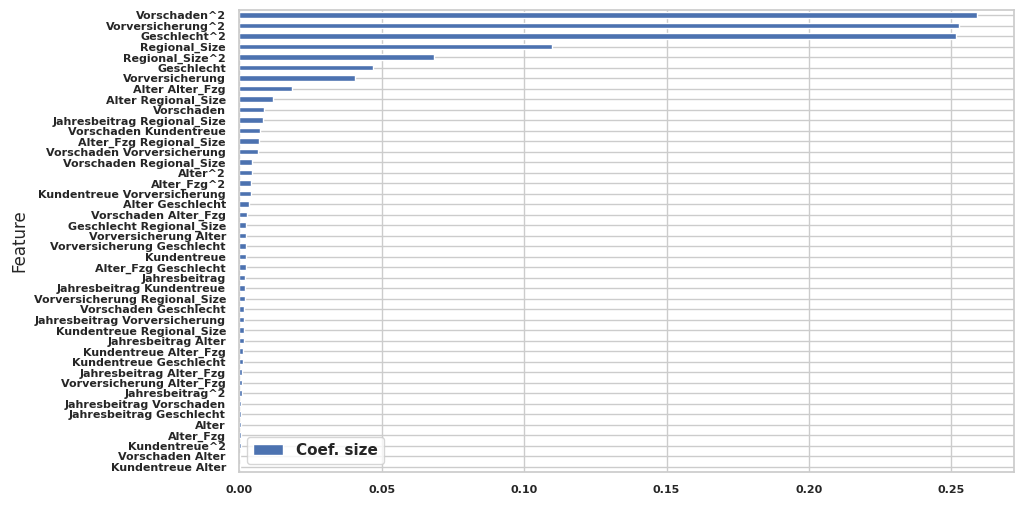

In [134]:
# Order coefficients by size
coefficients = selection_model[2].coef_[0]
feature_names = selection_model[:-1].get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coef. size': np.abs(coefficients)})
feature_importance = feature_importance.sort_values("Coef. size", ascending=True)
feature_importance.plot(x="Feature", y="Coef. size", kind="barh", figsize=(10, 6), fontsize=8)

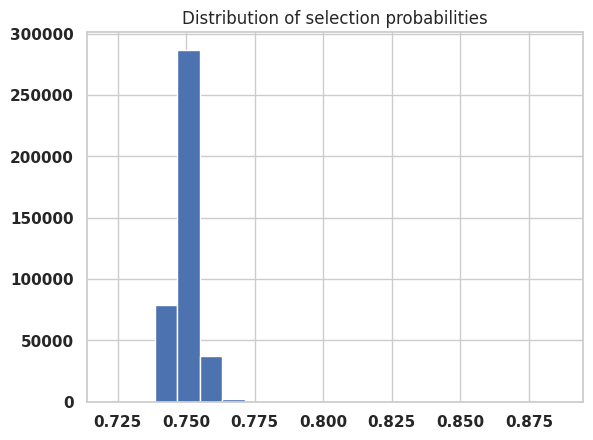

In [137]:
plt.hist(selection_prob_train, bins=20)
plt.title("Distribution of selection probabilities")
plt.show()

# Learnings:
# - no extreme selection probabilities

In [140]:
g80 = cbase.loc[(cbase["prob_selected"] >= 0.80)] # TODO: investigate these cases
g80.shape

(63, 16)

### Test for covariate shift
Simple test for covariate shift. Check classification performance of the selection model. 

In [168]:
from sklearn.metrics import accuracy_score, roc_auc_score

auroc_test = roc_auc_score(s_test, selection_prob_test, average=None)
auroc_train = roc_auc_score(s_train, selection_prob_train, average=None)

print(f"AUROC test/train: {auroc_test:.2f}/{auroc_train:.2f}")

AUROC test/train: 0.50/0.51


-> Proceed under covariate stability assumption.

## Step 2: Learn classifier for customer interest
- Classification problem with unequal misclassification costs: cost(FN) > cost(FP).
- Objective: Reliably predict customers with interest -> high probability of detection (recall) at acceptable levels of FPR.

In [185]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import f1_score #, roc_auc

# Filter survey customers
selected_df = cbase[cbase["selected"] == 1]
selected_df = cbase.loc[np.random.choice(selected_df.index, 100000, replace=False)] # TODO pull a stratified sample

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    selected_df[pred_cols], # use same predictors as in selection model
    selected_df["Interesse"],
    test_size=0.2,
    random_state=2024
)

# Design search grid
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_features": [None, "sqrt"],
    "max_depth": [None, 4] 
} # TODO: wider parameter grid

CV = 5

# Train model for Interesse
rf_search = GridSearchCV(estimator = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, bootstrap=False), 
                         param_grid = param_grid, cv = CV, verbose=2, n_jobs = 4, scoring="roc_auc")
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(bootstrap=False,
                                                      replacement=True,
                                                      sampling_strategy='all'),
             n_jobs=4,
             param_grid={'max_depth': [None, 4], 'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 400]},
             scoring='roc_auc', verbose=2)

In [186]:
# Train with best hyperparameter settings
best_params = rf_search.best_params_
print(f"Best hyperparameters: {best_params}")

rf_best = BalancedRandomForestClassifier(
    random_state=2024, 
    max_features=best_params["max_features"], 
    n_estimators=best_params["n_estimators"], 
    max_depth=best_params["max_depth"],
    sampling_strategy="all", replacement=True, bootstrap=False
)

best_model = rf_best.fit(X_train, y_train)

Best hyperparameters: {'max_depth': 4, 'max_features': None, 'n_estimators': 200}


In [187]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the best model on test set
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
auroc_best = roc_auc_score(y_test, y_pred_best, average=None)

# Compute AUROC on train set 
y_pred_train = best_model.predict(X_train)
auroc_train = roc_auc_score(y_train, y_pred_train, average=None)

# Compute average Jahresbeitrag on test set
gain = np.where(y_pred_best == 1, X_test["Jahresbeitrag"], 0)
average_gain = gain.sum()/y_pred.sum()

print(f"Recall: {recall_best:.2f}")
print(f"Precision: {precision_best:.2f}")
print(f"Accuracy: {accuracy_best:.2f}")
print(f"Predicted average Jahresbeitrag: {sum_average_gain:.2f}")
print(f"AUROC test/train: {auroc_best:.2f}/{auroc_train:.2f}")

Best hyperparameters: {'max_depth': 4, 'max_features': None, 'n_estimators': 200}
Recall: 0.95
Precision: 0.26
Accuracy: 0.67
Predicted average Jahresbeitrag: 32287.22
AUROC test/train: 0.79/0.79


In [188]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77     17602
         1.0       0.26      0.95      0.41      2398

    accuracy                           0.67     20000
   macro avg       0.62      0.79      0.59     20000
weighted avg       0.90      0.67      0.72     20000



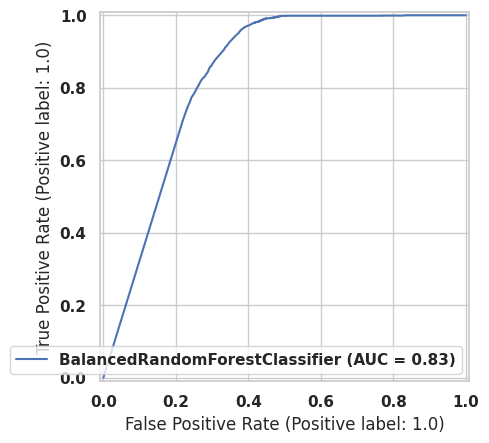

[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   8.1s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   6.9s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   7.9s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   5.9s
[CV] END max_depth=None, max_features=sqrt, n_estimators=200; total time=  11.3s
[CV] END max_depth=None, max_features=sqrt, n_estimators=200; total time=  10.8s
[CV] END max_depth=None, max_features=sqrt, n_estimators=400; total time=  21.8s
[CV] END ...max_depth=4, max_features=None, n_estimators=100; total time=   4.5s
[CV] END ...max_depth=4, max_features=None, n_estimators=200; total time=  12.4s
[CV] END ...max_depth=4, max_features=None, n_estimators=200; total time=   8.3s
[CV] END ...max_depth=4, max_features=None, n_estimators=400; total time=  16.3s
[CV] END ...max_depth=4, max_features=sqrt, n_estimators=100; total time=   2.7s
[CV] END ...max_depth=4, max

In [189]:
from sklearn.metrics import RocCurveDisplay

rf_roc = RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

# TODOs/next steps

* Try other model classes for the outcome process, e.g. lightGBM, naive Bayes
* Cost-sensitive learning: Incorporate `Jahresbeitrag` into model loss 
* Feature engineering, use target encoding for high-cardinality features
* Under NMAR: Heckman-type selection models, e.g [Brewer/Carlson 2024](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.3029)